In [1]:
%load_ext autoreload
%autoreload 2
import warnings
import numpy as np
import time
import os
from dotenv import load_dotenv
os.environ["USE_PYGEOS"] = "0"
import napari_sparrow as nas
from spatialdata import read_zarr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample 
import scanpy as sc
import seaborn as sns
import anndata as ad
%run own_and_modified_functions.ipynb
warnings.simplefilter(action='ignore')

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


In [2]:
OUTPUT_DIR = '/home/wout/Documents/Thesis_lokaal/Mouse_Liver_Resolve_Data'

In [3]:
anndataA11_all = sc.read(OUTPUT_DIR + '/' + 'A1-1/anndataNucA11_all.h5ad')
anndataA12_all = sc.read(OUTPUT_DIR + '/' + 'A1-2/anndataNucA12_all.h5ad')
anndataC2_all = sc.read(OUTPUT_DIR + '/' + 'C2/anndataNucC2_all.h5ad') 
anndataD21_all = sc.read(OUTPUT_DIR + '/' + 'D2-1/anndataNucD21_all.h5ad')

In [4]:
# Give Leiden clusters unique numbers over all samples
n_leiden_A11 = len(np.unique(anndataA11_all.obs['leiden']))
n_leiden_A12 = len(np.unique(anndataA12_all.obs['leiden']))
n_leiden_C2 = len(np.unique(anndataC2_all.obs['leiden']))
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(int)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(int) + n_leiden_A11
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(int) + n_leiden_A11 + n_leiden_A12 + n_leiden_C2
# reset to string
anndataA11_all.obs['leiden'] = anndataA11_all.obs['leiden'].astype(str)
anndataA12_all.obs['leiden'] = anndataA12_all.obs['leiden'].astype(str)
anndataC2_all.obs['leiden'] = anndataC2_all.obs['leiden'].astype(str)
anndataD21_all.obs['leiden'] = anndataD21_all.obs['leiden'].astype(str)

In [5]:
# concatenate all anndata objects
anndata_samples_together = anndataA11_all.concatenate(anndataA12_all, anndataC2_all, anndataD21_all)

In [6]:
print(anndataA11_all.obs.shape)
print(anndataA12_all.obs.shape)
print(anndataC2_all.obs.shape)
print(anndataD21_all.obs.shape)
print(anndata_samples_together.obs.shape) # batch 0 = A1-1, batch 1 = A1-2, batch 2 = C2, batch 3 = D2-1

(11283, 96)
(8695, 96)
(27133, 96)
(12519, 96)
(59630, 97)


Meso
[]
Fibr
[(75, 0.75, 83), (159, 0.64, 25), (219, 0.78, 201), (235, 0.81, 118), (361, 0.51, 138), (375, 0.73, 127), (496, 0.58, 89)]
Hepa
[(6, 1.0, 52), (7, 0.79, 52), (9, 0.98, 47), (12, 1.0, 41), (13, 0.98, 133), (14, 1.0, 40), (17, 0.97, 36), (18, 0.94, 36), (19, 0.86, 35), (20, 1.0, 35), (21, 0.94, 34), (23, 0.97, 31), (24, 0.98, 133), (25, 1.0, 24), (26, 1.0, 22), (28, 1.0, 15), (30, 1.0, 158), (31, 0.99, 148), (32, 0.94, 131), (33, 0.98, 120), (38, 0.91, 114), (39, 0.64, 113), (40, 0.54, 112), (41, 1.0, 111), (44, 0.99, 108), (45, 0.96, 107), (46, 0.97, 132), (47, 0.98, 105), (50, 0.94, 98), (51, 1.0, 97), (52, 1.0, 97), (53, 0.94, 96), (54, 0.98, 95), (55, 0.75, 95), (56, 0.95, 94), (58, 1.0, 93), (59, 0.97, 93), (62, 1.0, 89), (67, 1.0, 86), (68, 1.0, 131), (69, 0.99, 86), (70, 0.99, 85), (74, 0.96, 83), (78, 0.93, 81), (79, 0.99, 130), (82, 1.0, 80), (83, 0.99, 80), (84, 0.96, 80), (86, 0.97, 79), (87, 0.89, 79), (88, 0.99, 78), (89, 0.55, 78), (90, 0.96, 130), (92, 0.99, 7

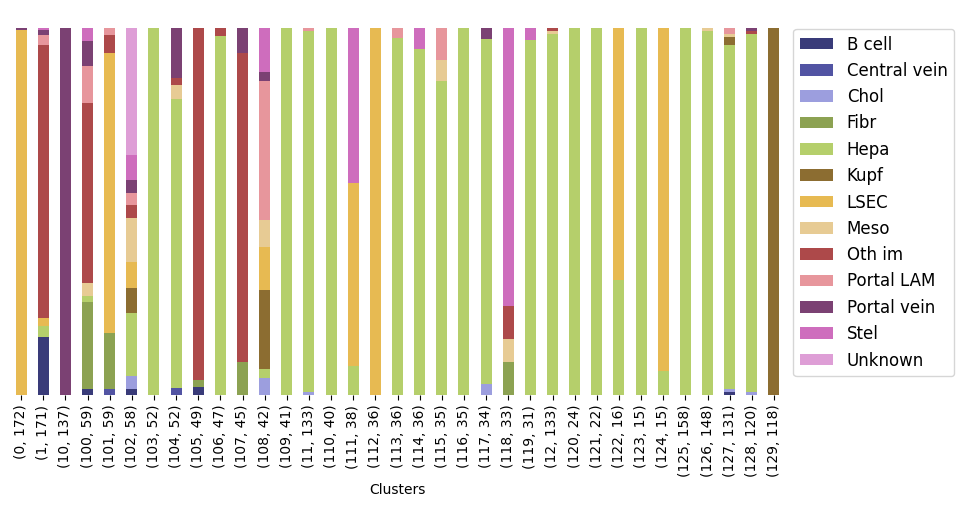

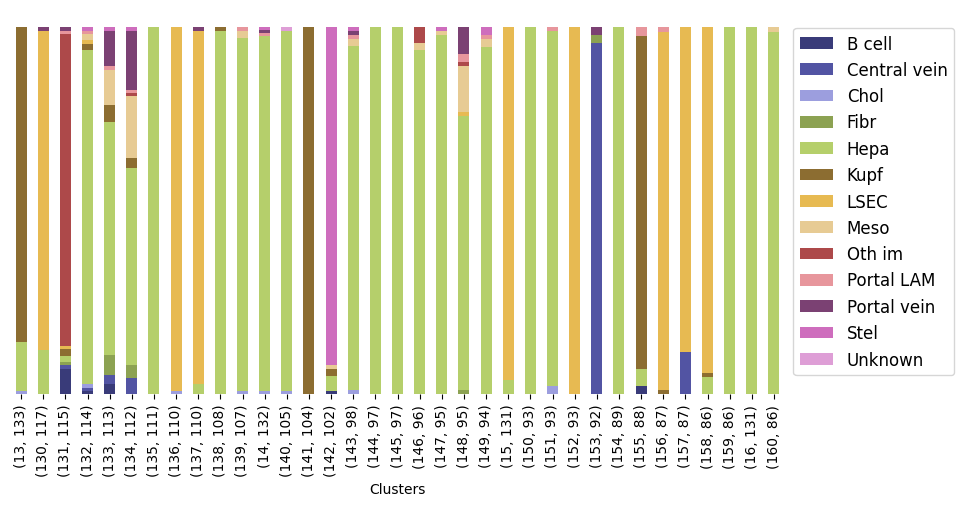

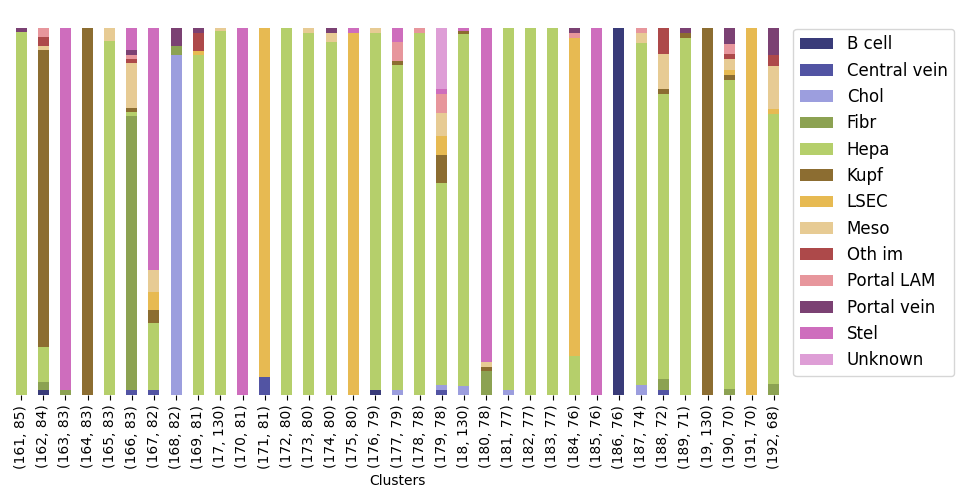

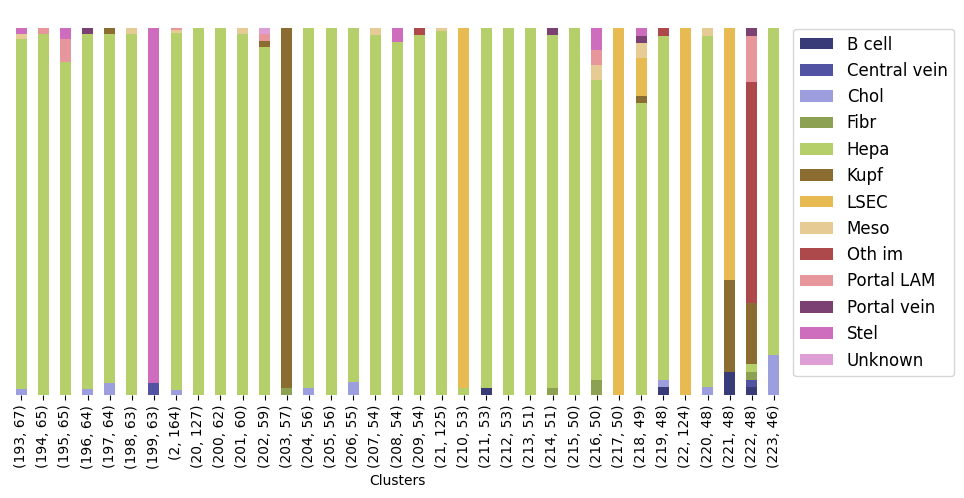

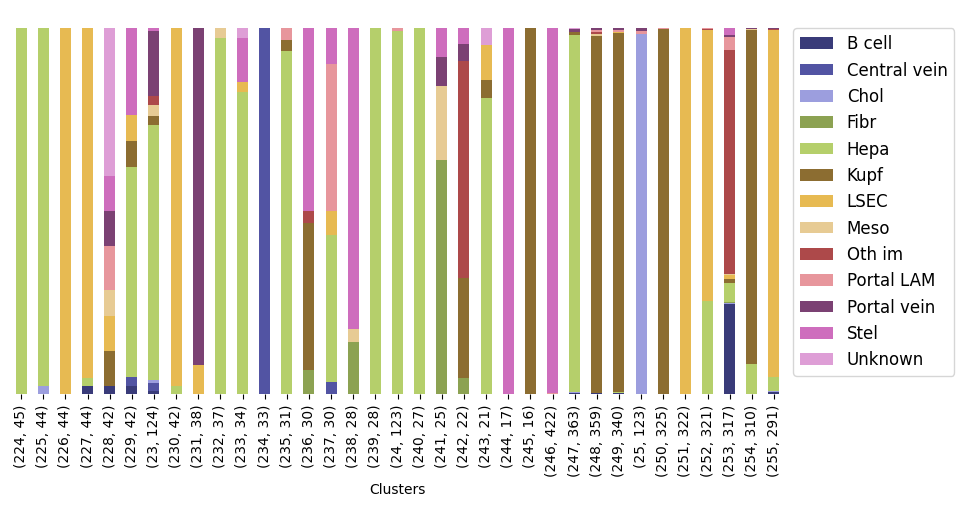

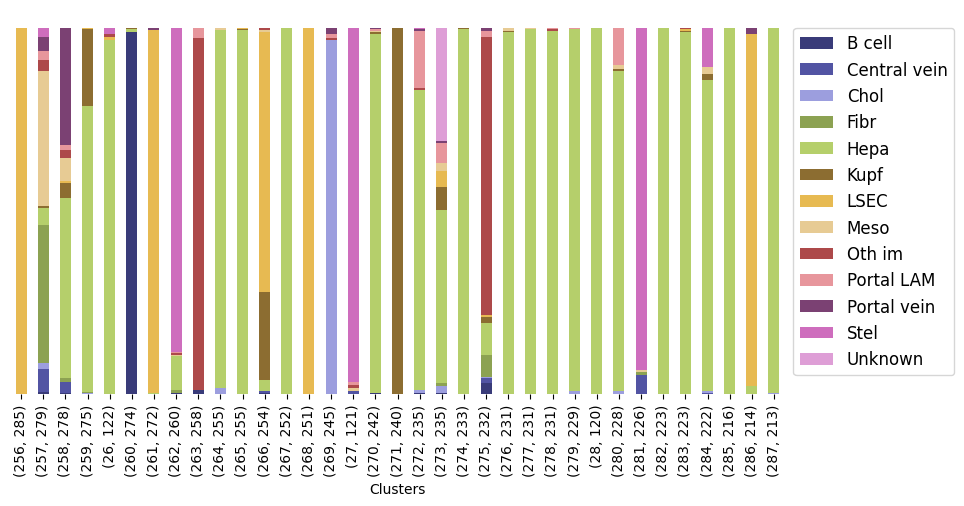

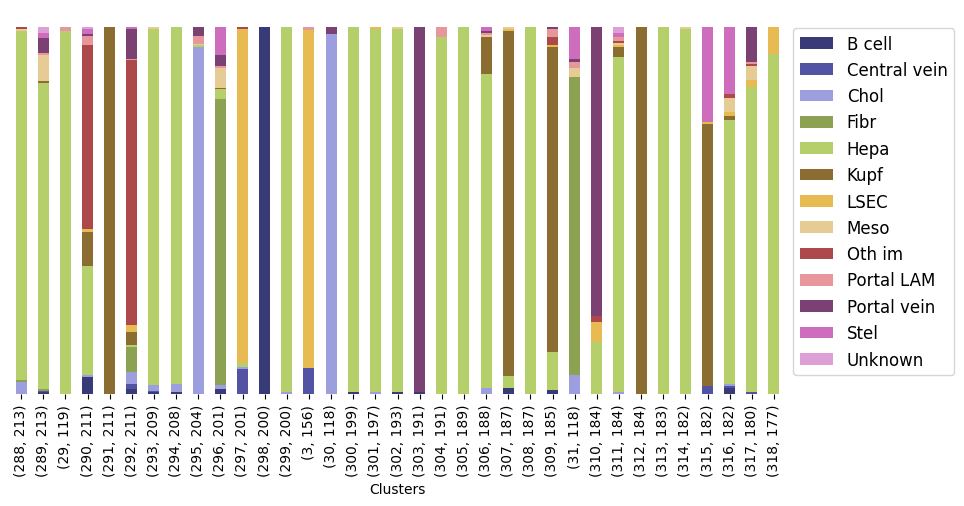

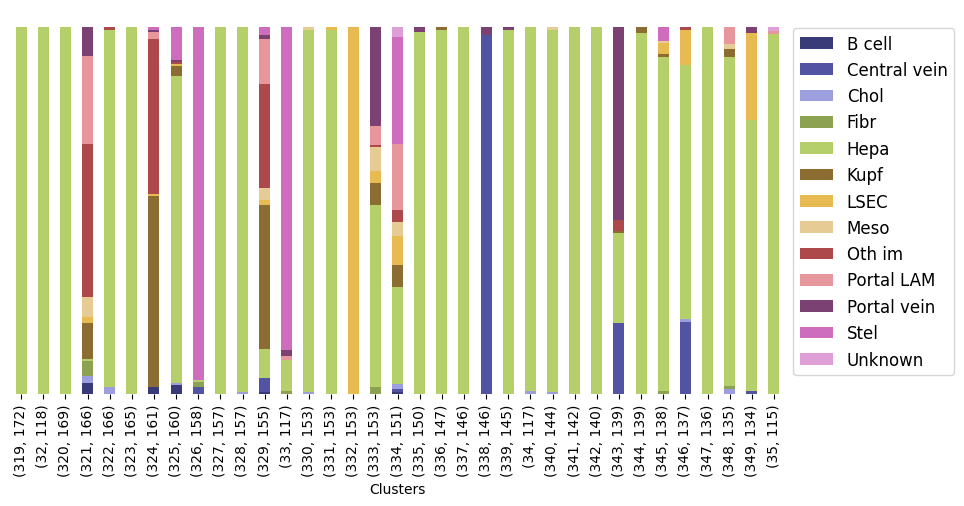

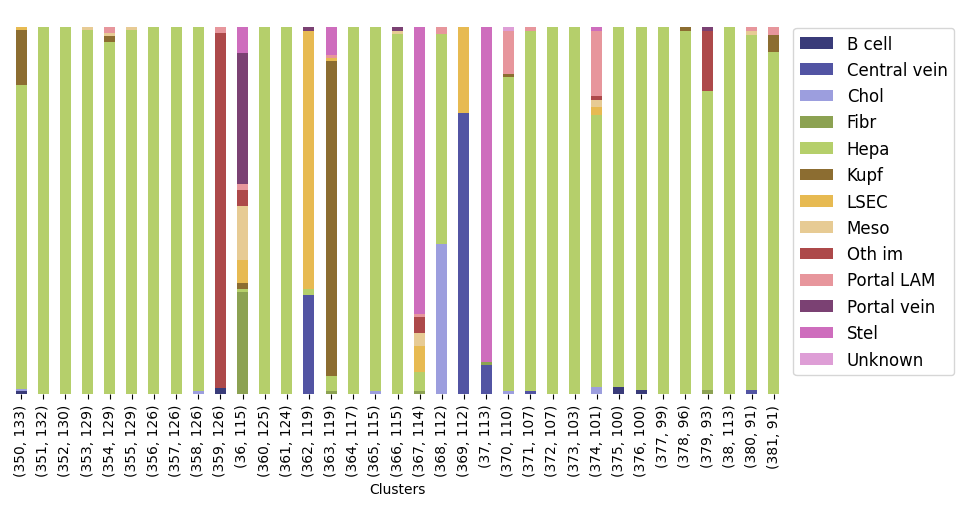

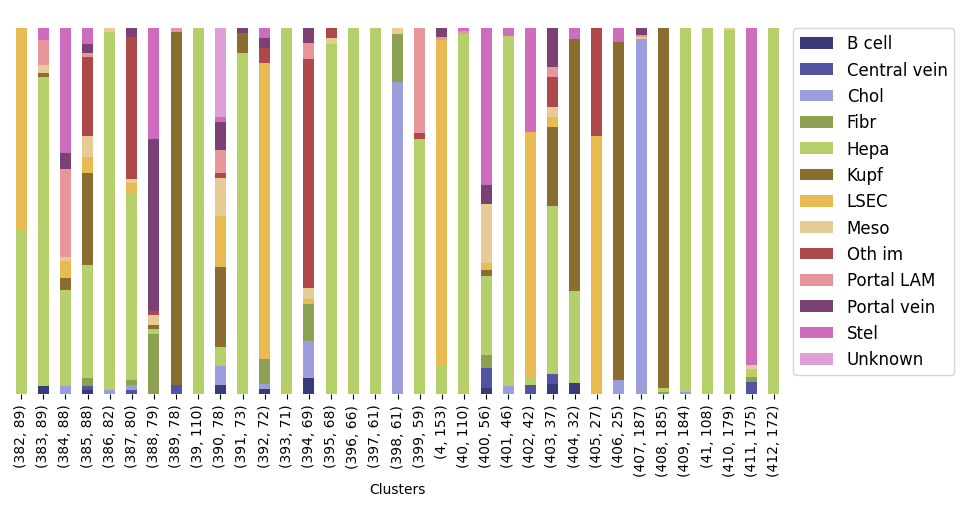

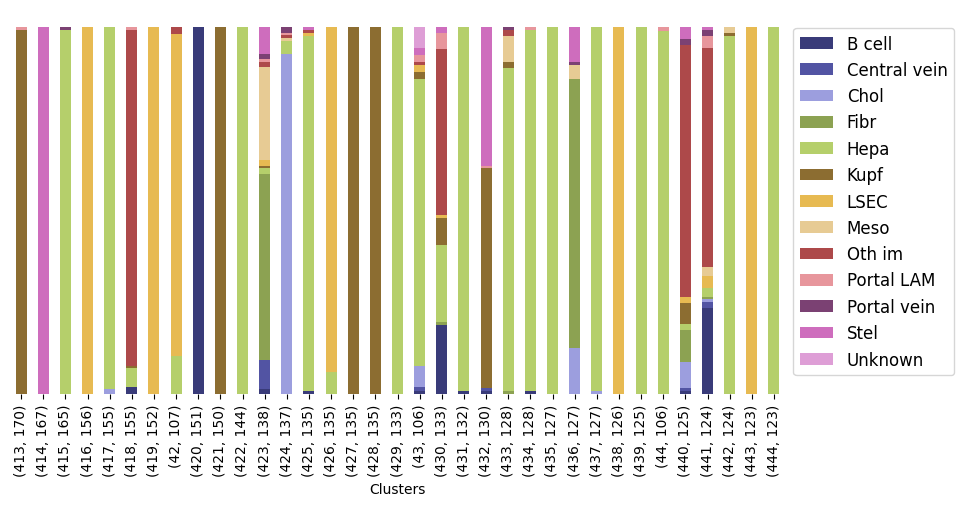

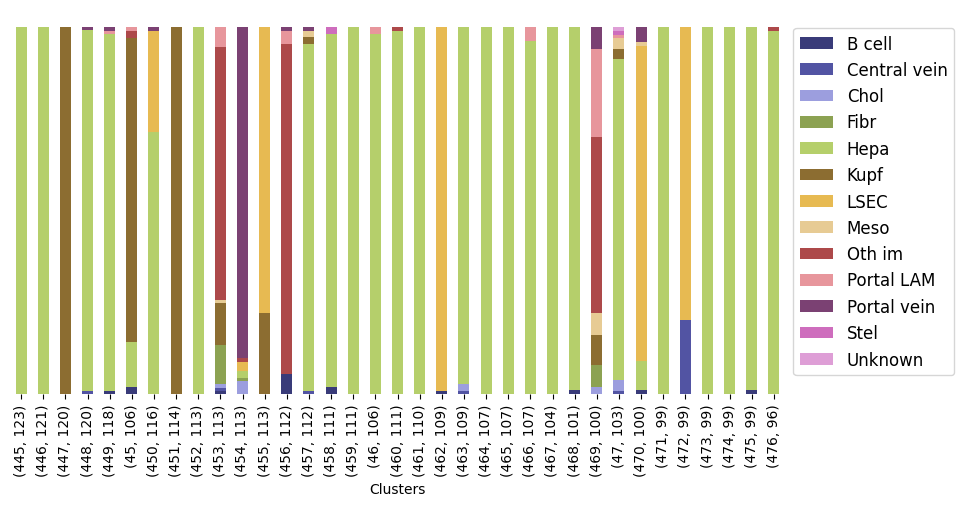

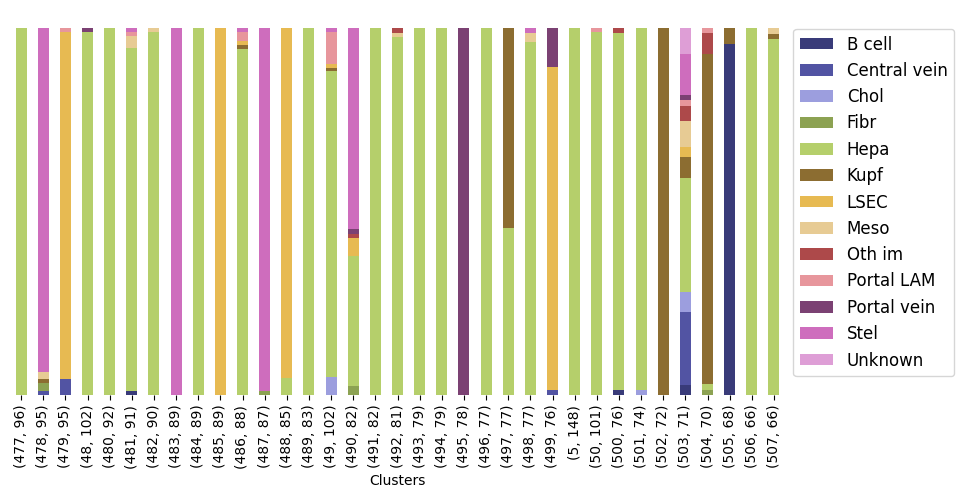

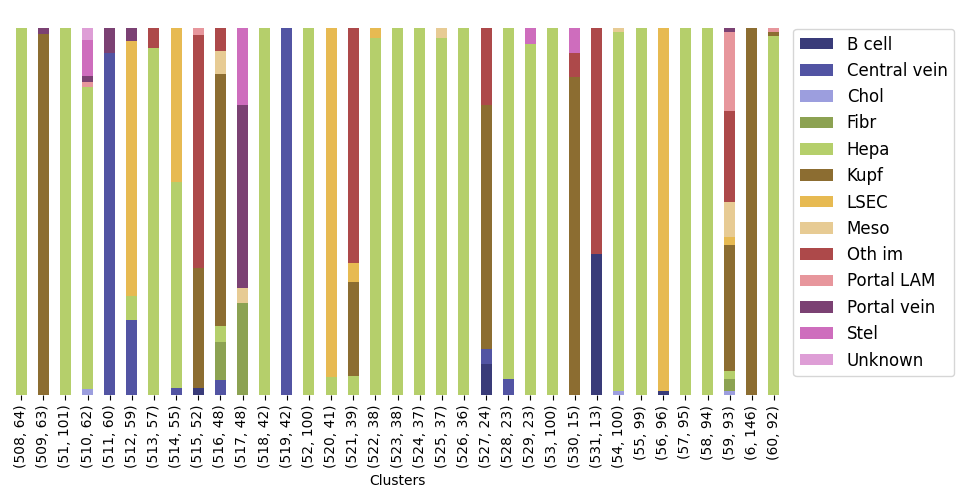

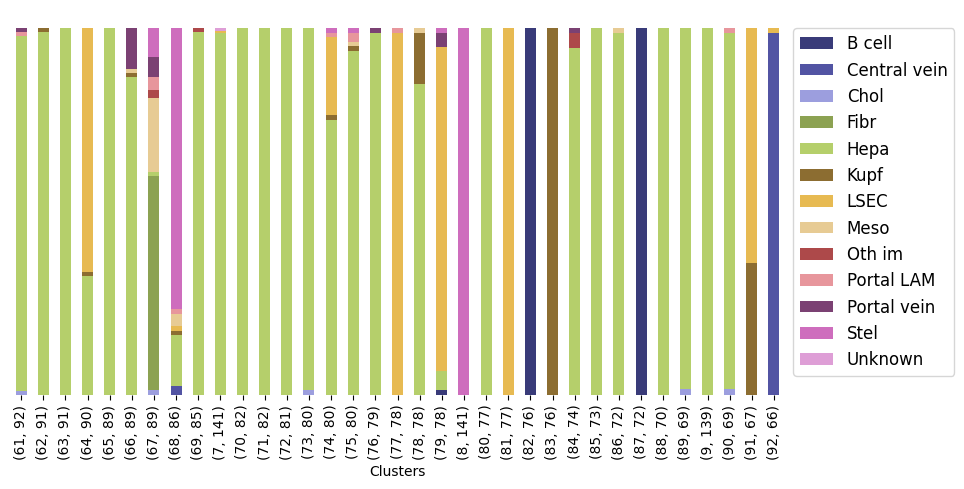

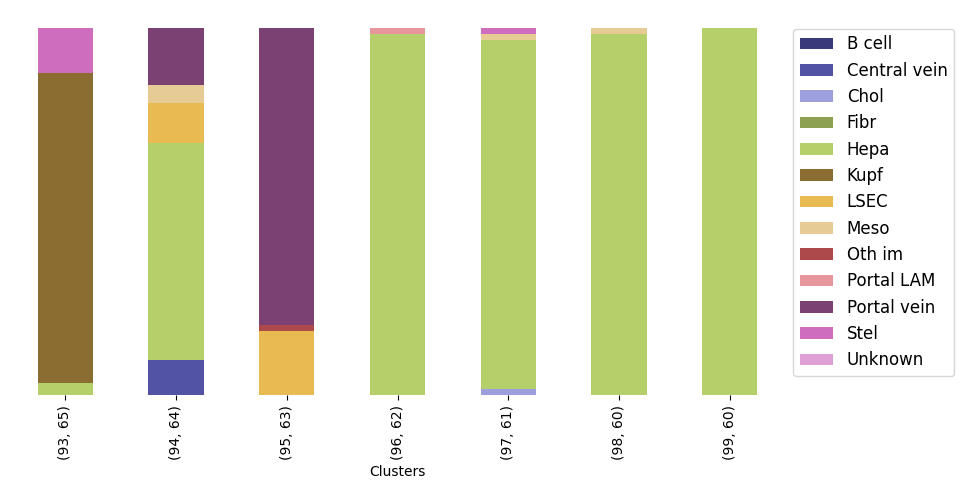

In [7]:
annotation = 'annotation_own_score_genes_Atlas_Scores_12'
path_mg = OUTPUT_DIR + '/' + 'AtlasSecondLevelScores.csv'
cell_types = anndata_samples_together.obs[annotation].unique().tolist()  
leiden_clusters_per_ct = clusteringVSleiden(anndata_samples_together,annotation,"leiden",cell_types=cell_types,print_results=True)

In [8]:
Apply_strategy_multiple_times(anndata_samples_together,annotation,path_mg,2,1,OUTPUT_DIR)

525 cells randomly sampled from each cell type in every iteration to do the DEG analysis


KeyboardInterrupt: 